# 数据聚合与分组操作

本章介绍一种自然的方式对数据集进行切片、切块和对数据总结，并将会学到：
+ 使用一个或多个键（形式可以是函数、数组或DataFrame列名）分割pandas对象。
+ 计算分组的汇总统计信息，比如数量、平均值或标准差，或是用户定义的函数。
+ 应用组内转换或其他运算，如规格化、线性回归、排名或选取子集等。
+ 计算透视表或交叉表。
+ 执行分位数分析以及其它统计分组分析。

>时间序列的聚合是groupby的特殊用例，在本书中被称作重采样，将在11章单独介绍

## GroupBy 机制

Hadley Wickham（许多热门R语言包的作者）创造了一个用于表示分组运算的术语"split-apply-combine"（拆分－应用－合并）。第一个阶段，pandas对象（无论是Series、DataFrame还是其他的）中的数据会根据你所提供的一个或多个键被拆分（split）为多组。拆分操作是在对象的特定轴上执行的。例如，DataFrame可以在其行（axis=0）或列（axis=1）上进行分组。然后，将一个函数应用（apply）到各个分组并产生一个新值。最后，所有这些函数的执行结果会被合并（combine）到最终的结果对象中。结果对象的形式一般取决于数据上所执行的操作。下图大致说明了一个简单的分组聚合过程。

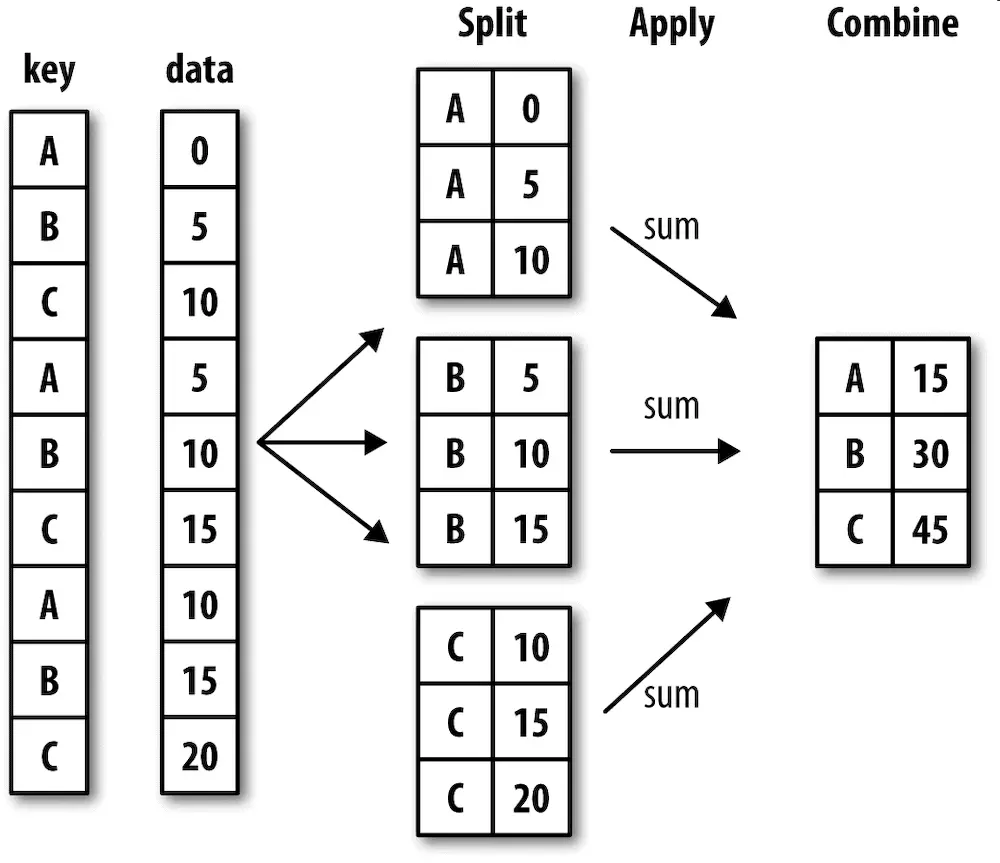

分组键可以是多种形式的，并且每个分组建的类型不强制是相同的：
+ 1.与待分组轴的长度一样的值列表或者值数组
+ 2.表示DataFrame某个列名的值
+ 3.字典或Series，可以给出待分组轴上的值与分组名之间的对应关系
+ 4.函数，用于处理轴索引或索引中的各个标签

请注意后三种都只是快捷方式，其最终目的仍然是产生一组用于拆分对象的值。如果觉得这些东西看起来很抽象，不用担心，在本章中会给出大量有关于此的示例。首先来看看下面这个非常简单的表格型数据集（以DataFrame的形式）：

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.DataFrame({'key1':list('aabba'),'key2':['one','two','one','two','one'],
                  'data1':np.random.randn(5),'data2':np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,0.851809,-0.091272
1,a,two,0.201049,2.488233
2,b,one,0.740823,1.580438
3,b,two,0.669588,-0.803642
4,a,one,-0.916338,-0.705094


假设想要根据key1标签计算data1列的平均值。实现该功能的方式有很多，这里可以通过访问data1，并根据key1调用groupby实现：

In [3]:
grouped = df['data1'].groupby(df['key1'])
#df.groupby(['by=None', 'axis=0', 'level=None', 'as_index=True', 'sort=True', 
#            'group_keys=True', 'squeeze=False', 'observed=False', '**kwargs'])
#by : mapping, function, label, or list of labels
#if a function, it's called on each value of the object's index.
#调用对象索引（即index）的每个值
grouped

变量grouped是一个GroupBy对象。它实际上还没有进行任何计算，只是含有一些有关分组键df\['key1'\]的中间数据而已。换句话说，该对象拥有接下来对各分组执行运算所需的一切信息。例如，可以调用GroupBy的mean方法来计算分组平均值：

In [4]:
grouped.mean()

key1
a    0.045507
b    0.705206
Name: data1, dtype: float64

稍后将详细讲解.mean()的调用过程。数据（Series）根据分组键进行了聚合，产生了一个新的Series，这个Series使用key1的列中的唯一值作为索引。由于原始DataFrame的列df\['key]，所以结果中的索引名称为key1，

如果一次传入多个数组的列表，就会得到不同的结果：

In [5]:
means = df['data1'].groupby([df['key1'],df['key2']]).mean()
means

key1  key2
a     one    -0.032264
      two     0.201049
b     one     0.740823
      two     0.669588
Name: data1, dtype: float64

这里使用了两个键对数据进行分组，得到的Series现在具有一个包含唯一键对的多层索引：

In [6]:
means.unstack()

key2,one,two
key1,,
a,-0.032264,0.201049
b,0.740823,0.669588


*上个例子中，分组键都是Series，实际上，分组键可以是任意**正确**长度的任何数组：*

In [7]:
states = np.array(['Ohio','California','California','Ohio','Ohio'])
years = np.array([2005,2005,2006,2005,2006])
df['data1'].groupby([states,years]).mean()

California  2005    0.201049
            2006    0.740823
Ohio        2005    0.760699
            2006   -0.916338
Name: data1, dtype: float64

一般，分组信息作为想要继续处理的数据会包含在同一个DataFrame中。这样，就可以直接传递列名称（无论它是字符串、数字或其他python对象）作为分组键：

In [8]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.045507,0.563956
b,0.705206,0.388398


In [9]:
df.groupby(['key1','key2']).mean()

data1     data2
key1 key2                    
a    one  -0.032264 -0.398183
     two   0.201049  2.488233
b    one   0.740823  1.580438
     two   0.669588 -0.803642

在df.groupby('key1').mean()的结果中并没有key2列，这是因为df\['key2'\]不是数值数据，即它是一个冗余列，因此被排除在结果之外。默认情况下，所有的数值列都可以聚合，虽然有时可能会被过滤为一个子集。

无论准备拿groupby做什么，都有可能会用到GroupBy的size方法，它可以返回一个含有分组大小的`Series`：

In [10]:
df.groupby(['key1','key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

>分组键中的任何缺失值都会被排除在结果之外

### 遍历各分组
+ 查看GroupBy对象的内容

GroupBy对象支持迭代，会生成一个包含分组名和数据块的2维元组序列。看下面的例子：

In [11]:
for name, group in df.groupby('key1'):
    print(name)
    print('-'*5)
    print(group)
    print('='*10)

a
-----
  key1 key2     data1     data2
0    a  one  0.851809 -0.091272
1    a  two  0.201049  2.488233
4    a  one -0.916338 -0.705094
b
-----
  key1 key2     data1     data2
2    b  one  0.740823  1.580438
3    b  two  0.669588 -0.803642


在多个分组键的情况下，元组的第一个元素将会是由键值组成的元组：

In [12]:
for (k1, k2), group in df.groupby(['key1','key2']):
    print((k1,k2))
    print('-'*5)
    print(group)
    print('='*10)

('a', 'one')
-----
  key1 key2     data1     data2
0    a  one  0.851809 -0.091272
4    a  one -0.916338 -0.705094
('a', 'two')
-----
  key1 key2     data1     data2
1    a  two  0.201049  2.488233
('b', 'one')
-----
  key1 key2     data1     data2
2    b  one  0.740823  1.580438
('b', 'two')
-----
  key1 key2     data1     data2
3    b  two  0.669588 -0.803642


可以选择在任何一快数据上进行想要的操作。下面的代码可以返回数据块的字典：

In [13]:
pieces = dict(list(df.groupby('key1')))
pieces['b']

,key1,key2,data1,data2
2,b,one,0.740823,1.580438
3,b,two,0.669588,-0.803642


groupby默认是在axis=0上进行分组的，通过设置也可以在其他任何轴上进行分组。例如：我们可以根据dtype对列进行分组：

In [14]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [15]:
grouped = df.groupby(df.dtypes,axis=1)

可以打印各分组：

In [16]:
for dtype, group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0  0.851809 -0.091272
1  0.201049  2.488233
2  0.740823  1.580438
3  0.669588 -0.803642
4 -0.916338 -0.705094
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


### 选择一列或者所有列的子集

对于由DataFrame产生的GroupBy对象，如果用一个（单个字符串）或一组（字符串数组）列名对其进行索引，就能实现选取部分列进行聚合的目的。也就是说：

    df.groupby('key1')['data1']
    df.groupby('key1')[['data2']]

是下面代码的语法糖：

    df['data1'].groupby(df['key'])
    df[['data2']].groupby(df['key1'])
    
其对于大数据集，很可能只需要对部分列进行聚合。例如，在前面那个数据集中，如果只需计算data2列的平均值并以DataFrame形式得到结果，可以这样写：

In [17]:
df.groupby(['key1','key2'])[['data2']].mean()

data2
key1 key2          
a    one  -0.398183
     two   2.488233
b    one   1.580438
     two  -0.803642

**如果传入的是列表或数组，则此索引操作所返回的是一个已分组的`DataFrame对象`（比如上面代码的结果）；如果传入的是标量形式的单个列名，则是已分组的`Series`：**

In [18]:
df.groupby(['key1','key2'])['data2'].mean()

key1  key2
a     one    -0.398183
      two     2.488233
b     one     1.580438
      two    -0.803642
Name: data2, dtype: float64

### 使用字典和Series分组

分组信息还可能以非数组形式存在：

In [19]:
people = pd.DataFrame(np.random.randn(5,5),columns=list('abcde'),
                     index=['Joe','Steve','Wes','Jim','Travis'])
people

,a,b,c,d,e
Joe,0.532694,-2.359855,-0.634900,0.101838,0.642016
Steve,0.097236,0.012562,-0.703863,0.878718,-0.019869
Wes,-0.668700,1.247712,-0.541424,2.001065,2.042535
Jim,0.211347,-0.759627,-1.134087,0.254133,0.608295
Travis,-1.182306,-1.048761,-1.913339,0.494836,0.274920


In [20]:
people.iloc[2:3,[1,2]] = np.nan #Add a few NA values
people

,a,b,c,d,e
Joe,0.532694,-2.359855,-0.634900,0.101838,0.642016
Steve,0.097236,0.012562,-0.703863,0.878718,-0.019869
Wes,-0.668700,NaN,NaN,2.001065,2.042535
Jim,0.211347,-0.759627,-1.134087,0.254133,0.608295
Travis,-1.182306,-1.048761,-1.913339,0.494836,0.274920


假设已经知道各列的分组对应关系，并且想把各列按组列加：

In [21]:
mapping = {'a':'red','b':'red','c':'blue','d':'blue','e':'red','f':'orange'}
mapping

{'a': 'red', 'b': 'red', 'c': 'blue', 'd': 'blue', 'e': 'red', 'f': 'orange'}

现在可以根据这个字典构造一个数组，或者直接传递这个字典：
>这里多写了'f'键，用于表明未用的分组键也是没问题的

In [22]:
people.groupby(mapping,axis=1).sum()

,blue,red
Joe,-0.533062,-1.185145
Steve,0.174856,0.089929
Wes,2.001065,1.373835
Jim,-0.879954,0.060016
Travis,-1.418503,-1.956147


Series也可以直接传递给groupby，可以将其视为固定大小的映射：

In [23]:
map_series = pd.Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [24]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### 使用函数分组

比起使用字典或Series，使用Python函数是一种更原生的方法定义分组映射。任何被当做分组键的函数都会在各个索引值上被调用一次，其返回值就会被用作分组名称。具体点说，以上一小节的示例DataFrame为例，其索引值为人的名字。你可以计算一个字符串长度的数组，更简单的方法是传入len函数：

In [25]:
people.groupby(len).sum()

,a,b,c,d,e
3,0.075341,-3.119482,-1.768987,2.357036,3.292846
5,0.097236,0.012562,-0.703863,0.878718,-0.019869
6,-1.182306,-1.048761,-1.913339,0.494836,0.274920


将函数与数组、字典或Series进行混合并不困难，所有的对象都会在内部转换维数组：

In [26]:
key_list = ['one','one','one','two','two']
people.groupby([len,key_list]).min()

a         b         c         d         e
3 one -0.668700 -2.359855 -0.634900  0.101838  0.642016
  two  0.211347 -0.759627 -1.134087  0.254133  0.608295
5 one  0.097236  0.012562 -0.703863  0.878718 -0.019869
6 two -1.182306 -1.048761 -1.913339  0.494836  0.274920

### 根据索引的层级分组

分层索引的数据集有一个非常方便的地方，就是能够在轴索引的某个层级上进行聚合：

In [27]:
columns = pd.MultiIndex.from_arrays([['US','US','US','JP','JP'],
                                    [1,3,5,1,3]],
                                   names=['city','tenor'])
hier_df = pd.DataFrame(np.random.randn(4,5),columns=columns)
hier_df

city         US                            JP          
tenor         1         3         5         1         3
0     -0.524507 -0.721362 -1.300731 -0.167186 -0.014931
1     -0.322688 -0.265026  1.550846 -0.886722 -0.348917
2     -1.052880 -1.181626  1.477501 -0.732249 -0.625840
3     -1.972427 -3.104010  0.899497  0.379722  0.752135

**根据层级分组时，将层级数值或层级名称传递给level关键字：**
+ 即如果对象含有多层索引，使用level=层级数值或层级名称来分组

In [28]:
hier_df.groupby(level='city',axis=1).count()

city,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


In [29]:
hier_df.groupby(level=0,axis=1).count()

city,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## 数据聚合
+ agg是aggregate的别名，以后使用agg

聚合指的是任何能够从数组产生标量值的数据转换过程。之前的例子已经用过一些聚合操作，比如mean、count、min以及sum等。许多常见的聚合运算（如下表）都有进行优化。然而，不必局限于这些方法：

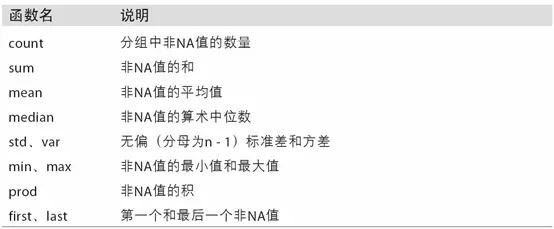

可以使用自己发明的聚合运算，还可以调用分组对象上已经定义好的任何方法。例如，quantile可以计算Series或DataFrame列的样本分位数。

尽管quantile并没有明确地表明可以用于Groupby对象，但是quantile是Series方法，所以可以用于聚合：

In [30]:
df

,key1,key2,data1,data2
0,a,one,0.851809,-0.091272
1,a,two,0.201049,2.488233
2,b,one,0.740823,1.580438
3,b,two,0.669588,-0.803642
4,a,one,-0.916338,-0.705094


In [31]:
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)
#df.quantile(q=0.5, axis=0, numeric_only=True, interpolation='linear')

key1
a    0.721657
b    0.733700
Name: data1, dtype: float64

要使用自定义的聚合函数，需要将函数当作参数传递给aggregate或agg方法：

In [32]:
def peak_to_peak(arr):
    return arr.max() - arr.min()

grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,1.768147,3.193327
b,0.071235,2.384081


describe函数也是可以可以用于groupby对象的，尽管严格来说它们并不是聚合函数：

In [33]:
grouped.describe().T

key1                a         b
data1 count  3.000000  2.000000
      mean   0.045507  0.705206
      std    0.894277  0.050370
      min   -0.916338  0.669588
      25%   -0.357644  0.687397
      50%    0.201049  0.705206
      75%    0.526429  0.723014
      max    0.851809  0.740823
data2 count  3.000000  2.000000
      mean   0.563956  0.388398
      std    1.694499  1.685800
      min   -0.705094 -0.803642
      25%   -0.398183 -0.207622
      50%   -0.091272  0.388398
      75%    1.198481  0.984418
      max    2.488233  1.580438

>自定义聚合函数要比表中那些经过优化的函数慢得多。这是因为在构造中间分组数据块时存在额外的开销（函数调用、数据重排等）。

### 逐列及多函数应用

使用read_csv载入数据后，增加一个小费比例列tip_pct：

In [34]:
tips = pd.read_csv('C:/Users/lenovo/data_of_python/examples/tips.csv')
tips.head()

,total_bill,tip,smoker,day,time,size
0,16.99,1.01,No,Sun,Dinner,2
1,10.34,1.66,No,Sun,Dinner,3
2,21.01,3.50,No,Sun,Dinner,3
3,23.68,3.31,No,Sun,Dinner,2
4,24.59,3.61,No,Sun,Dinner,4


In [35]:
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


前面介绍了对Series和DataFrame所有列的聚合操作，即调用aggregate和所需函数，或直接调用聚合函数如mean()。但是，也可以根据各列同时使用多个函数进行聚合，根据day和smoker来对tips进行分组：
+ 将函数名以字符串传形式传递给agg或aggregate

In [36]:
grouped = tips.groupby(['day','smoker'])
grouped_pct = grouped['tip_pct']
grouped_pct.aggregate('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

若传递的是一个包含函数或函数名的列表，就会获得一个列名是这些函数名的DataFrame：

In [37]:
grouped_pct.agg(['mean','std',peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

>arr中列表中的聚合函数都会被应用于分组数据

可以通过传递二元元组（name，function）的列表，对生成的DataFrame中列进行命名：

In [38]:
grouped_pct.agg([('foo','mean'),('bar',np.std)])
#或
#grouped_pct.agg([('foo','mean'),('bar','std')])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

将**相同**聚合函数应用到一个或多个列上：

In [39]:
functions = ['count','mean','max']
result = grouped['tip_pct','total_bill'].agg(functions)
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

同样可以更改在DataFrame中的列名：

In [40]:
ftuples = [('Durchschnitt','mean'),('Abweichung',np.var)]
grouped['tip_pct','total_bill'].agg(ftuples)

tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

将**不同**的函数应用到一个或多个列上，实现这个功能需要给agg方法传递字典：

In [41]:
grouped.agg({'tip_pct':np.max,'size':'sum'})

tip_pct  size
day  smoker                
Fri  No      0.187735     9
     Yes     0.263480    31
Sat  No      0.291990   115
     Yes     0.325733   104
Sun  No      0.252672   167
     Yes     0.710345    49
Thur No      0.266312   112
     Yes     0.241255    40

In [42]:
grouped.agg({'tip_pct':['min','max','mean','std'],'size':'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

>只有多个函数应用在至少一个列上时，DataFrame才具有分层列

### 返回不含有“行索引（分组键）”的聚合数据

前面的例子中有唯一的分组键作为行索引被返回，现可以通过向groupby传递as_index=False来禁用分组键作为索引的行为：

In [43]:
tips.groupby(['day','smoker'],as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


也可以通过reset_index()获得同样的结果

In [44]:
a = tips.groupby(['day','smoker']).mean()
a.reset_index()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


## Apply：一般性的“拆分－应用－合并”

最通用的GroupBy方法是apply，本节剩余部分将重点讲解它。如下图所示，apply会将待处理的对象拆分成多个片段，然后对各片段调用传入的函数，最后尝试将各片段组合到一起。

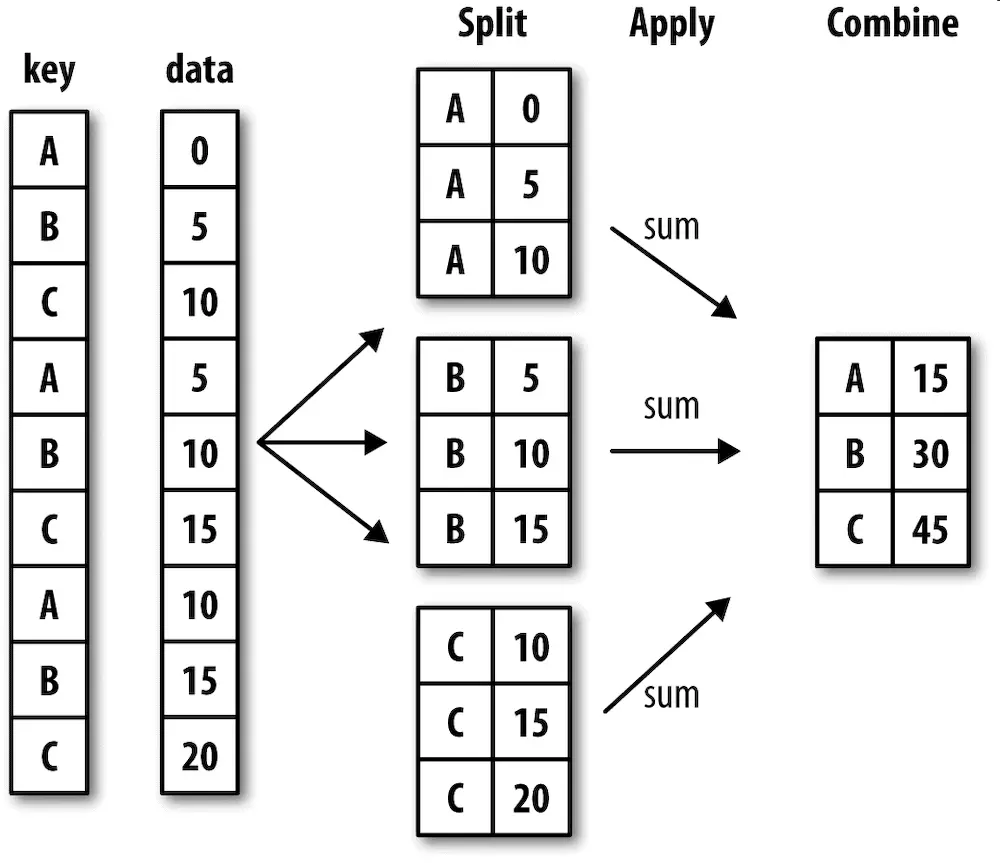

回到之前那个小费数据集，假设想要根据分组选出最高的5个tip_pct值。首先，写一个可以在特定列中选出最大值所在行的函数：

In [45]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column,ascending=False)[:n]
top(tips,n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
232,11.61,3.39,No,Sat,Dinner,2,0.291990
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525


先按照smoker进行分组，然后调用apply，得到如下结果：

In [46]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     232       11.61  3.39     No   Sat  Dinner     2  0.291990
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       88        24.71  5.85     No  Thur   Lunch     2  0.236746
Yes    172        7.25  5.15    Yes   Sun  Dinner     2  0.710345
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       109       14.31  4.00    Yes   Sat  Dinner     2  0.279525

在上述的例子中，top函数在DataFrame的每一行分组上被调用，之后结果由pandas.concat组装到一起，并以分组名称进行了标记。于是，最终结果就有了一个层次化索引，其内层索引值来自原DataFrame的行索引值(index)。

如果传给apply的函数能够接受其他参数或关键字，则可以将这些内容放在函数名后面一并传入：

In [47]:
tips.groupby(['smoker','day']).apply(top,n=3,column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
            91        22.49   3.50     No   Fri  Dinner     2  0.155625
            223       15.98   3.00     No   Fri   Lunch     3  0.187735
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
            59        48.27   6.73     No   Sat  Dinner     4  0.139424
            23        39.42   7.58     No   Sat  Dinner     4  0.192288
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
            112       38.07   4.00     No   Sun  Dinner     3  0.105070
            11        35.26   5.00     No   Sun  Dinner     4  0.141804
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
            85        34.83   5.17     No  Thur   Lunch     4  0.148435
            141       34.30   6.70     No  Thur   Lunch     6  0.195335
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
            90        28.97   3.00    Yes   Fri  Dinner     2  0.103555
            96        27.28   4.00    Yes   Fri  Dinner     2  0.146628
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
            102       44.30   2.50    Yes   Sat  Dinner     3  0.056433
            207       38.73   3.00    Yes   Sat  Dinner     4  0.077459
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
            184       40.55   3.00    Yes   Sun  Dinner     2  0.073983
            180       34.65   3.68    Yes   Sun  Dinner     4  0.106205
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982
            83        32.68   5.00    Yes  Thur   Lunch     2  0.152999
            192       28.44   2.56    Yes  Thur   Lunch     2  0.090014

>查看apply的帮助：
help(pd.core.groupby.groupby.DataFrameGroupBy.apply)

之前在groupby对象上调用了describe方法：

In [48]:
result = tips.groupby('smoker')['tip_pct'].describe()
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [49]:
result.unstack()

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

>在GroupBy对象的内部，当调用像describe这样的方法时，实际上是以下代码的简写：  
    f = lambda x: x.describe()  
    grouped.apply(f)

### 禁用分组键

在之前的例子中，分组键会和原始对象的索引共同构成结果对象中的层次化索引。将group_keys=False传入groupby即可禁止该效果：

In [50]:
tips.groupby('smoker',group_keys=False).apply(top).head()

,total_bill,tip,smoker,day,time,size,tip_pct
232,11.61,3.39,No,Sat,Dinner,2,0.291990
149,7.51,2.00,No,Thur,Lunch,2,0.266312
51,10.29,2.60,No,Sun,Dinner,2,0.252672
185,20.69,5.00,No,Sun,Dinner,5,0.241663
88,24.71,5.85,No,Thur,Lunch,2,0.236746


In [51]:
tips.groupby('smoker').apply(top).head()

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     232       11.61  3.39     No   Sat  Dinner     2  0.291990
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       88        24.71  5.85     No  Thur   Lunch     2  0.236746

### 分位数与桶分析

之前介绍的cut和qcut函数，可以将数据按照给定的箱位或样本分位数进行分桶。若将它们与groupby方法一起使用，可以对数据集更方便的进行分桶或分位分析：

In [52]:
frame = pd.DataFrame({'data1':np.random.randn(1000),
                     'data2':np.random.randn(1000)})
quartiles = pd.cut(frame.data1,4)
quartiles.head()

0    (-1.572, 0.0337]
1    (-1.572, 0.0337]
2      (0.0337, 1.64]
3      (0.0337, 1.64]
4      (0.0337, 1.64]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-3.185, -1.572] < (-1.572, 0.0337] < (0.0337, 1.64] < (1.64, 3.246]]

In [53]:
pd.value_counts(quartiles)

(0.0337, 1.64]      460
(-1.572, 0.0337]    425
(-3.185, -1.572]     61
(1.64, 3.246]        54
Name: data1, dtype: int64

cut返回的Categorical对象可以直接传递给groupby，即根据Categorical分组：

In [54]:
def get_stats(group):
    return {'min':group.min(),'max':group.max(),'count':group.count(),'mean':group.mean()}
grouped = frame.data2.groupby(quartiles)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.185, -1.572]",61.0,2.730662,-0.164617,-2.088106
"(-1.572, 0.0337]",425.0,4.030207,-0.001791,-3.494043
"(0.0337, 1.64]",460.0,3.114568,-0.003622,-2.910237
"(1.64, 3.246]",54.0,1.996998,-0.082863,-2.826099


 cut函数分的桶是等组距的桶，可以使用qcut函数根据样本分位数计算出大小相等的桶。另，可以用labels=False禁用标签

In [55]:
grouping = pd.qcut(frame.data1, 10, labels=False)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,2.730662,-0.154238,-2.306180
1,100.0,4.030207,-0.133393,-2.409460
2,100.0,3.264279,0.066227,-3.494043
3,100.0,2.371574,0.074312,-2.306587
4,100.0,3.114568,0.045683,-2.278225
5,100.0,2.148338,-0.282638,-2.910237
6,100.0,2.272725,0.278047,-2.142315
7,100.0,2.021907,-0.057762,-2.373691
8,100.0,3.029096,-0.082832,-2.681019


### 示例：使用指定分组值填充缺失值

在清除缺失值时，可以使用dropna方法来去除缺失值。除此之外，也可以使用fillna方法将修正值或者来自于其他数据的值来填充null值：

In [56]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1   -0.686419
2         NaN
3   -0.812348
4         NaN
5   -1.502904
dtype: float64

In [57]:
s.fillna(s.mean())

0   -1.000557
1   -0.686419
2   -1.000557
3   -0.812348
4   -1.000557
5   -1.502904
dtype: float64

可以结合apply方法和fillna方法对不同的组填充不同的缺失值：

In [58]:
states = ['Ohio', 'New York','Vermont','Florida','Oregon','Nevada','California','Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = pd.Series(np.random.randn(8), index=states)
data[['Vermont','Nevada','Idaho']] = np.nan
data

Ohio          0.454780
New York     -1.205503
Vermont            NaN
Florida      -0.380174
Oregon        1.033346
Nevada             NaN
California    1.068577
Idaho              NaN
dtype: float64

In [59]:
data.groupby(group_key).mean()#不考虑nan值

East   -0.376966
West    1.050961
dtype: float64

In [60]:
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio          0.454780
New York     -1.205503
Vermont      -0.376966
Florida      -0.380174
Oregon        1.033346
Nevada        1.050961
California    1.068577
Idaho         1.050961
dtype: float64

另一种方法：可以在代码中预定义各组的填充值。因为每个分组都有一个内置的name属性：

In [61]:
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])
data.groupby(group_key).apply(fill_func)

Ohio          0.454780
New York     -1.205503
Vermont       0.500000
Florida      -0.380174
Oregon        1.033346
Nevada       -1.000000
California    1.068577
Idaho        -1.000000
dtype: float64

### 示例：随机采样与排列

随机采样可以使用Series的sample方法来实现：

In [62]:
suits = list('HSCD')
card_val = (list(range(1,11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2,11)) + list('JKQ')
cards = []
for suit in list('HSCD'):
    cards.extend(str(num) + suit for num in base_names)

deck = pd.Series(card_val, index=cards)
deck.head()

AH    1
2H    2
3H    3
4H    4
5H    5
dtype: int64

现在我们已经创建了长度为52的Series，Series的索引包含了牌名，Series的值可以用于Blackjack和其他游戏（为了保持简单，令A为1）。

现在，从整幅牌中抽取五张牌：

In [63]:
def draw(deck, n=5):
    return deck.sample(n)

draw(deck)

AH     1
JC    10
4D     4
9H     9
6D     6
dtype: int64

从每种花色中随机抽取两张牌：

In [64]:
get_suit = lambda card: card[-1] #last letter is suit
deck.groupby(get_suit).apply(draw, n=2)

C  JC    10
   7C     7
D  2D     2
   9D     9
H  9H     9
   4H     4
S  8S     8
   AS     1
dtype: int64

可以禁用标签：

In [65]:
deck.groupby(get_suit,group_keys=False).apply(draw,n=2)

10C    10
3C      3
10D    10
JD     10
JH     10
9H      9
QS     10
10S    10
dtype: int64

### 示例：分组加权平均和相关系数

#### 分组加权平均

根据groupby的“拆分－应用－合并”范式，可以进行DataFrame的列与列之间或两个Series之间的运算（比如分组加权平均）。以下面这个数据集为例，它含有分组键、值以及一些权重值：

In [66]:
df = pd.DataFrame({'category':list('aaaabbbb'),'data':np.random.randn(8),'weights':np.random.rand(8)})
df

,category,data,weights
0,a,-0.342431,0.343534
1,a,0.437264,0.874831
2,a,-1.393599,0.545609
3,a,1.247685,0.878407
4,b,0.568110,0.097726
5,b,-0.444005,0.118493
6,b,0.820868,0.059883
7,b,-0.199897,0.465926


category分组后，对其进行加权平均：

In [67]:
grouped = df.groupby('category')
get_wavg = lambda g: np.average(g['data'],weights=g['weights'])
grouped.apply(get_wavg)

category
a    0.227262
b   -0.055354
dtype: float64

#### 相关系数

+ Dataframe.pct_change()计算当前值与前一个值的百分比变化，正数表示增加，负数表示减少  
+ DataFrame.corrwith()计算两个DataFrame对象的行或列之间的成对相关系数。  
+ DataFrame.corr()计算列之间的相关系数，不包含缺失值。  

下面请看具体的例子：

In [68]:
close_px = pd.read_csv('C:/Users/lenovo/data_of_python/examples/stock_px_2.csv',parse_dates=True,index_col=0)
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


In [69]:
close_px.head()

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93
2003-01-08,7.28,21.31,28.83,909.93


In [70]:
spx_corr = lambda x: x.corrwith(x['SPX'])
rets = close_px.pct_change().dropna()
get_year = lambda x: x.year
by_year = rets.groupby(get_year)
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


计算DataFrame内部列的相关性：

In [71]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### 示例：逐组线性回归

使用groupby进行更复杂的分组统计分析，例如定义regress（回归）函数，该函数对`每个数据块`执行普通最小二乘回归：

In [72]:
import statsmodels.api as sm

In [73]:
def regress(data, yvar, xvar):
    Y = data[yvar]
    X = data[xvar]
    X['intercept'] = 1
    result = sm.OLS(Y, X).fit()
    return result.params

计算AAPL在SPX回报上的年度线性回归：

In [74]:
by_year.apply(regress, ['AAPL'],['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


>groupby[\['var'\]]会返回一个DataFrame  
>groupby\['var'\]会返回一个Series

## 数据透视表与交叉表

### 透视表

pandas可以根据pandas.pivot_table()或者DataFrame.pivot_table()生成一个数据透视表，下面时pivot_table（）方法或函数的参数：

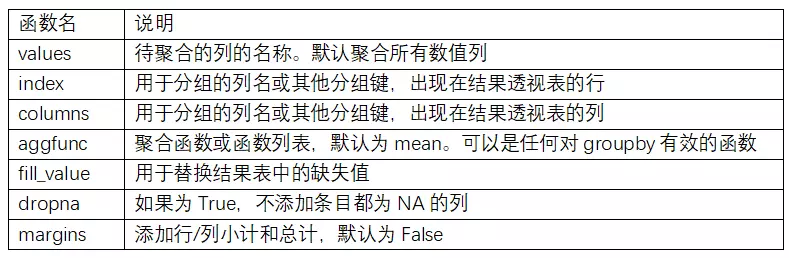

具体的例子：

In [129]:
tips.pivot_table(index=['day','smoker'])

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

In [131]:
tips.pivot_table(['tip_pct','size'],index=['time','day'],columns='smoker')

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

In [132]:
tips.pivot_table(['tip_pct','size'],index=['time','day'],columns='smoker',margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

In [136]:
tips.pivot_table(['tip_pct'],index=['time','smoker'],columns='day',margins=True)

tip_pct                                        
day                 Fri       Sat       Sun      Thur       All
time   smoker                                                  
Dinner No      0.139622  0.158048  0.160113  0.159744  0.158653
       Yes     0.165347  0.147906  0.187250       NaN  0.160828
Lunch  No      0.187735       NaN       NaN  0.160311  0.160920
       Yes     0.188937       NaN       NaN  0.163863  0.170404
All            0.169913  0.153152  0.166897  0.161276  0.160803

In [137]:
tips.pivot_table(['tip_pct'],index=['time','size','smoker'],columns='day',fill_value=0)

tip_pct                              
day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
            Yes     0.000000  0.144995  0.152660  0.000000
       4    No      0.000000  0.150096  0.148143  0.000000
            Yes     0.117750  0.124515  0.193370  0.000000
       5    No      0.000000  0.000000  0.206928  0.000000
            Yes     0.000000  0.106572  0.065660  0.000000
       6    No      0.000000  0.000000  0.103799  0.000000
Lunch  1    No      0.000000  0.000000  0.000000  0.181728
            Yes     0.223776  0.000000  0.000000  0.000000
       2    No      0.000000  0.000000  0.000000  0.166005
            Yes     0.181969  0.000000  0.000000  0.158843
       3    No      0.187735  0.000000  0.000000  0.084246
            Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

### 交叉表：crosstab（是一个函数）

crosstab计算的时分组中的频数：

In [77]:
Sample = range(1,11)
Nationality = ['USA']+['Japan']+['USA']+['Japan']*3+['USA']*2+['Japan']+['USA']
Handedness = ['Right-handed']+['Left-handed']+['Right-handed']*2+['Left-handed']+['Right-handed']*2+['Left-handed']+['Right-handed']*2
data = pd.DataFrame({'Sample':Sample,'Nationality':Nationality,'Handedness':Handedness})
data

,Sample,Nationality,Handedness
0,1,USA,Right-handed
1,2,Japan,Left-handed
2,3,USA,Right-handed
3,4,Japan,Right-handed
4,5,Japan,Left-handed
5,6,Japan,Right-handed
6,7,USA,Right-handed
7,8,USA,Left-handed
8,9,Japan,Right-handed
9,10,USA,Right-handed


In [78]:
pd.crosstab(data.Nationality, data.Handedness,margins=True)
#pd.crosstab(['index', 'columns', 'values=None', 
#             'rownames=None', 'colnames=None', 'aggfunc=None', 
#             'margins=False', "margins_name='All'", 'dropna=True', 'normalize=False'])

Handedness,Left-handed,Right-handed,All
Nationality,,,
Japan,2,3,5
USA,1,4,5
All,3,7,10


行索引是分层索引：

In [79]:
pd.crosstab([tips.time,tips.day],tips.smoker,margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

>参数values可以省略